<a href="https://colab.research.google.com/github/kittisaktaoma/colab_practice/blob/master/CalcSynergy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library 



In [ ]:
! wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
! chmod +x Miniconda3-latest-Linux-x86_64.sh
! ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
! conda config --set always_yes yes --set changeps1 no
! conda install -q -y -c conda-forge python=3.7
! conda install -q -y -c conda-forge rdkit==2020.09.2 

In [3]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem

In [ ]:
! pip install keras
! pip install tensorflow
! pip install keras-gcn
! pip install numpy
! pip install matplotlib
! pip install scipy
! pip install deepchem
! pip install keras-tuner
! pip install pubchempy
! pip install chembl_webresource_client

In [5]:
import deepchem as dc
import tensorflow as tf
import tensorflow.keras.layers as layers
import pandas as pd
import numpy as np
import deepchem as dc
from rdkit import Chem
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import BayesianOptimization
from chembl_webresource_client.new_client import new_client
import tensorflow as tf
from tensorflow.keras.backend import variable, dot as k_dot, sigmoid, relu
from tensorflow.keras.layers import Dense, Input, Concatenate, Layer
import numpy as np
import urllib
import pubchempy as pcp
import random 


In [6]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.pooling import MaxPooling1D
from keras.layers.merge import concatenate
from keras.preprocessing.sequence import pad_sequences

#Toy data

In [8]:
sample_01 = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/sample.txt",sep="\t").iloc[:,1]
sample_02 = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/sample.txt",sep="\t").iloc[:,2]
all_sample = sample_01.append(sample_02).unique()
all_sample

array(['5-FU', 'ABT-888', 'AZD1775', 'BEZ-235', 'BORTEZOMIB',
       'CARBOPLATIN', 'CYCLOPHOSPHAMIDE', 'DASATINIB', 'DEXAMETHASONE',
       'DINACICLIB', 'DOXORUBICIN', 'ERLOTINIB', 'ETOPOSIDE',
       'GELDANAMYCIN', 'GEMCITABINE', 'L778123', 'LAPATINIB', 'METFORMIN',
       'METHOTREXATE', 'MITOMYCINE', 'MK-2206', 'MK-4541', 'MK-4827',
       'MK-5108', 'MK-8669', 'MRK-003', 'OXALIPLATIN', 'PACLITAXEL',
       'PD325901', 'SN-38', 'SORAFENIB', 'SUNITINIB', 'TEMOZOLOMIDE',
       'TOPOTECAN', 'VINBLASTINE', 'VINORELBINE', 'ZOLINZA',
       'CHEMBL17639', 'BUSULFAN', 'AZACYTIDINE', 'FLUDARABINE BASE',
       'TENIPOSIDE', 'NSC733504', 'EXEMESTANE', 'BLEOMYCIN',
       'ANTIBIOTIC AD 32', 'MITOXANTRONE', "5-FLUORO-2'-DEOXYURIDINE",
       'MITOTANE', 'METHOXSALEN', 'FULVESTRANT', 'CARMUSTINE',
       'ADM HYDROCHLORIDE', 'TAMOXIFEN CITRATE', 'CHEMBL277800',
       'ALLOPURINOL', 'THIOTEPA', 'MERCAPTOPURINE', 'ANTIBIOTIC AY 22989',
       'IFOSFAMIDE', 'ANASTROZOLE', 'VINCRISTINE SULFAT

#Feature Preparation

##Drug structure


In [ ]:
drug_smiles = {}
for i in all_sample:
  try:
    print(i)
    res = pcp.get_compounds(i, 'name')
    SM = res[0].canonical_smiles   
    drug_smiles[i] = SM
  except Exception:
    pass

In [14]:
list(drug_smiles.keys()).__len__()

124

In [15]:
tmp_list = []
feat_mat = {}

curated_df = pd.DataFrame(drug_smiles.items(), columns=['Name', 'smiles'])

for i in range(curated_df.shape[0]):

  """
  create normalize adjacency matrix
  """

  mol = Chem.MolFromSmiles(curated_df.iloc[i,1])
  A = Chem.GetAdjacencyMatrix(mol).tolist()
  I = np.eye(A.__len__())

  A_hat = np.array(A + I)

  """
  create feaature matrix
  """

  f1 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetIsAromatic() for j in range(mol.GetNumAtoms())]]).T
  f2 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetNumRadicalElectrons() for j in range(mol.GetNumAtoms())]]).T
  X = np.array(pd.concat([f1,f2],axis=1)).astype(int)

  """
  multiplication A_hat*X
  """

  tmp_res = A_hat @ X

  """
  Padding matrix
  """

  tmp_list.append(tmp_res)

  if i == (curated_df.shape[0]-1):
      max_atom_number = max([tmp_list[i].__len__() for i in range(curated_df.shape[0])])
      tmp_pad = pad_sequences(tmp_list, padding='post',maxlen=max_atom_number)
      
      for j in range(curated_df.shape[0]):
        feat_mat[curated_df.iloc[j,0]] = tmp_pad[j]

In [16]:
feat_mat

{'1-(5-DEOXYPENTOFURANOSYL)-5-FLUORO-4-{[(PENTYLOXY)CARBONYL]AMINO}PYRIMIDIN-2(1H)-ONE': array([[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [1, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [1, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],


##Target protein

In [ ]:
target_protein = {}
for i in all_sample:
  try:
    print(i)
    c = pcp.get_compounds(i, 'name')
    pubmed_query_length = str(c[0].cid).__len__()
    add_length = 8 - int(pubmed_query_length)
    stitch_cid = "CIDs"+ '0'*int(add_length) + str(c[0].cid)
    target_prot = np.array(pd.read_csv("http://stitch.embl.de/api/tsv/interactors?identifier="+stitch_cid+"&species=9606",sep="\t").iloc[1:,:])
    target_protein[i] = target_prot
  except Exception:
    pass


In [ ]:
target_protein

###protein ID conversion

In [ ]:
test = [list(target_protein.values())[i].tolist() for i in range(len(target_protein))]
test_01 = sum(sum(test, []),[])
final = [s.replace('9606.',"") for s in test_01]
len(final)

945

In [ ]:
#! pip install stringdb
import stringdb
string_ids = stringdb.get_string_ids(final)
enrichment_df = stringdb.get_enrichment(string_ids.queryItem)
enrichment_df

,category,term,number_of_genes,number_of_genes_in_background,ncbiTaxonId,inputGenes,preferredNames,p_value,fdr,description
0,Process,GO:0050896,399,7824,9606,"ENSP00000001008,ENSP00000001146,ENSP0000001380...","FKBP4,CYP26B1,ERCC1,MYOC,MAPK1,HMOX1,FKBP3,APE...",1.320000e-80,9.400000e-77,response to stimulus
1,Process,GO:0070887,244,2672,9606,"ENSP00000001008,ENSP00000001146,ENSP0000021583...","FKBP4,CYP26B1,MAPK1,HMOX1,APEX1,GSR,TGFB1,HGF,...",4.750000e-80,1.690000e-76,cellular response to chemical stimulus
2,Process,GO:0042221,296,4153,9606,"ENSP00000001008,ENSP00000001146,ENSP0000001380...","FKBP4,CYP26B1,ERCC1,MAPK1,HMOX1,APEX1,AHCY,GSR...",2.800000e-78,6.660000e-75,response to chemical
3,Process,GO:0051716,352,6212,9606,"ENSP00000001008,ENSP00000001146,ENSP0000001380...","FKBP4,CYP26B1,ERCC1,MYOC,MAPK1,HMOX1,FKBP3,APE...",1.380000e-74,2.470000e-71,cellular response to stimulus
4,Process,GO:0010033,242,2815,9606,"ENSP00000001008,ENSP00000001146,ENSP0000001380...","FKBP4,CYP26B1,ERCC1,MAPK1,HMOX1,APEX1,TGFB1,HG...",3.970000e-74,5.660000e-71,response to organic substance
...,...,...,...,...,...,...,...,...,...,...
5030,NetworkNeighborAL,CL:21700,9,131,9606,"ENSP00000217426,ENSP00000219431,ENSP0000025503...","AHCY,MPG,CRP,GGH,DHFRL1,ALAS1,GGT1,GGT2,DHFR",6.900000e-03,3.850000e-02,"mixed, incl. alpha-amino acid metabolic proces..."
5031,NetworkNeighborAL,CL:13762,4,28,9606,"ENSP00000262193,ENSP00000270586,ENSP0000035532...","PSMB1,PSMB6,PSMB5,PSMB2",7.000000e-03,3.880000e-02,Proteasome
5032,NetworkNeighborAL,CL:19893,11,181,9606,"ENSP00000216911,ENSP00000217133,ENSP0000024843...","AURKA,TUBB1,TUBA4A,TUBG1,PLK4,TUBA1A,TUBB,TUBB...",7.000000e-03,3.880000e-02,"mixed, incl. Recruitment of NuMA to mitotic ce..."
5033,NetworkNeighborAL,CL:989,7,86,9606,"ENSP00000264144,ENSP00000264187,ENSP0000034667...","LAMC2,NID1,FYN,ITGAL,DMD,SRC,YES1",7.200000e-03,3.930000e-02,"mixed, incl. ECM-receptor interaction, and cel..."


In [ ]:
PI3K_gene = enrichment_df[enrichment_df.category == "KEGG"]
PI3K_gene

,category,term,number_of_genes,number_of_genes_in_background,ncbiTaxonId,inputGenes,preferredNames,p_value,fdr,description
3533,KEGG,hsa05200,129,515,9606,"ENSP00000211122,ENSP00000215832,ENSP0000021611...","GSTA3,MAPK1,HMOX1,TGFB1,HGF,RPS6KB1,IL2,CCND1,...",7.780000e-83,2.100000e-80,Pathways in cancer
3534,KEGG,hsa04151,83,348,9606,"ENSP00000215832,ENSP00000222390,ENSP0000022547...","MAPK1,HGF,CSF3,RPS6KB1,IL2,CCND1,IL4,FLT3,RAF1...",7.320000e-51,9.880000e-49,PI3K-Akt signaling pathway
3535,KEGG,hsa01521,43,78,9606,"ENSP00000215832,ENSP00000222390,ENSP0000022557...","MAPK1,HGF,RPS6KB1,RAF1,KRAS,PDGFRA,PDGFRB,MAPK...",8.680000e-39,7.810000e-37,EGFR tyrosine kinase inhibitor resistance
3536,KEGG,hsa05206,50,149,9606,"ENSP00000215832,ENSP00000216117,ENSP0000022750...","MAPK1,HMOX1,CCND1,RAF1,KRAS,PDGFRA,MDM2,THBS1,...",1.310000e-36,8.850000e-35,MicroRNAs in cancer
3537,KEGG,hsa05205,52,195,9606,"ENSP00000215832,ENSP00000221930,ENSP0000022239...","MAPK1,TGFB1,HGF,RPS6KB1,CCND1,SMO,RAF1,KRAS,MD...",6.780000e-34,3.660000e-32,Proteoglycans in cancer
...,...,...,...,...,...,...,...,...,...,...
3722,KEGG,hsa00592,3,25,9606,"ENSP00000312286,ENSP00000333142,ENSP00000356436","PLA2G1B,PLA2G6,PLA2G4A",2.910000e-02,4.140000e-02,alpha-Linolenic acid metabolism
3723,KEGG,hsa04714,11,228,9606,"ENSP00000225577,ENSP00000244289,ENSP0000025607...","RPS6KB1,LIPE,KRAS,PPARG,RPTOR,MTOR,NRAS,PRKAA2...",3.080000e-02,4.350000e-02,Thermogenesis
3724,KEGG,hsa00130,2,10,9606,"ENSP00000319788,ENSP00000348234","NQO1,TAT",3.260000e-02,4.570000e-02,Ubiquinone and other terpenoid-quinone biosynt...
3725,KEGG,hsa04713,6,93,9606,"ENSP00000215832,ENSP00000254657,ENSP0000026302...","MAPK1,PER2,MAPK3,FOS,CREB1,PRKCA",3.250000e-02,4.570000e-02,Circadian entrainment


In [ ]:
PI3K_gene_list = PI3K_gene.iloc[1,5].split(",")
PI3K_gene_list_02 = ["9606."+i for i in PI3K_gene_list]
PI3K_gene_list_02

['9606.ENSP00000215832',
 '9606.ENSP00000222390',
 '9606.ENSP00000225474',
 '9606.ENSP00000225577',
 '9606.ENSP00000226730',
 '9606.ENSP00000227507',
 '9606.ENSP00000231449',
 '9606.ENSP00000241453',
 '9606.ENSP00000251849',
 '9606.ENSP00000252723',
 '9606.ENSP00000256078',
 '9606.ENSP00000257290',
 '9606.ENSP00000257904',
 '9606.ENSP00000417281',
 '9606.ENSP00000260356',
 '9606.ENSP00000286301',
 '9606.ENSP00000261937',
 '9606.ENSP00000263025',
 '9606.ENSP00000263826',
 '9606.ENSP00000263923',
 '9606.ENSP00000263967',
 '9606.ENSP00000264144',
 '9606.ENSP00000264498',
 '9606.ENSP00000265171',
 '9606.ENSP00000266970',
 '9606.ENSP00000267101',
 '9606.ENSP00000267843',
 '9606.ENSP00000268035',
 '9606.ENSP00000269305',
 '9606.ENSP00000269571',
 '9606.ENSP00000270139',
 '9606.ENSP00000275493',
 '9606.ENSP00000276927',
 '9606.ENSP00000282397',
 '9606.ENSP00000288135',
 '9606.ENSP00000297494',
 '9606.ENSP00000299767',
 '9606.ENSP00000302150',
 '9606.ENSP00000302486',
 '9606.ENSP00000302564',


In [ ]:
tmp_dict = {}

for i in range(len(target_protein)):
  query_list = set(sum(list(target_protein.values())[i].tolist(),[]))
  ref_list = set(PI3K_gene_list_02)
  res_list = list(query_list & ref_list)
  tmp_dict[list(target_protein.keys())[i]] = res_list


In [ ]:
res_tmp = pd.DataFrame(tmp_dict.items())


,0,1
0,5-FU,"[9606.ENSP00000276927, 9606.ENSP00000269305, 9..."
1,ABT-888,"[9606.ENSP00000418960, 9606.ENSP00000275493]"
2,AZD1775,[]
3,BEZ-235,"[9606.ENSP00000263967, 9606.ENSP00000354558, 9..."
4,BORTEZOMIB,"[9606.ENSP00000269305, 9606.ENSP00000376943]"
...,...,...
117,RUXOLITINIB,"[9606.ENSP00000343204, 9606.ENSP00000371067, 9..."
118,VANDETANIB,"[9606.ENSP00000263923, 9606.ENSP00000275493, 9..."
119,NSC707389,[]
120,NSC256439,[]


##Boolean

In [ ]:
# Some code to return a Pandas dataframe, given tabular text

def to_df(result):
    return pd.read_table(io.StringIO(result), header=None)

! pip install Bio
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
import pandas as pd
import io

result = REST.kegg_link("hsa", "hsa04151").read()
to_df(result)


In [ ]:
s = REST.kegg_get("hsa04151","kgml").read()
print(s)

<?xml version="1.0"?>
<!DOCTYPE pathway SYSTEM "http://www.kegg.jp/kegg/xml/KGML_v0.7.2_.dtd">
<!-- Creation date: Oct 3, 2019 10:15:14 +0900 (GMT+9) -->
<pathway name="path:hsa04151" org="hsa" number="04151"
         title="PI3K-Akt signaling pathway"
         image="http://www.kegg.jp/kegg/pathway/hsa/hsa04151.png"
         link="http://www.kegg.jp/kegg-bin/show_pathway?hsa04151">
    <entry id="5" name="cpd:C05981" type="compound"
        link="http://www.kegg.jp/dbget-bin/www_bget?C05981">
        <graphics name="C05981" fgcolor="#000000" bgcolor="#FFFFFF"
             type="circle" x="423" y="568" width="8" height="8"/>
    </entry>
    <entry id="6" name="hsa:1977 hsa:253314 hsa:9470" type="gene"
        link="http://www.kegg.jp/dbget-bin/www_bget?hsa:1977+hsa:253314+hsa:9470">
        <graphics name="EIF4E, AUTS19, CBP, EIF4E1, EIF4EL1, EIF4F, eIF-4E..." fgcolor="#000000" bgcolor="#BFFFBF"
             type="rectangle" x="1099" y="88" width="46" height="17"/>
    </entry>
    <e

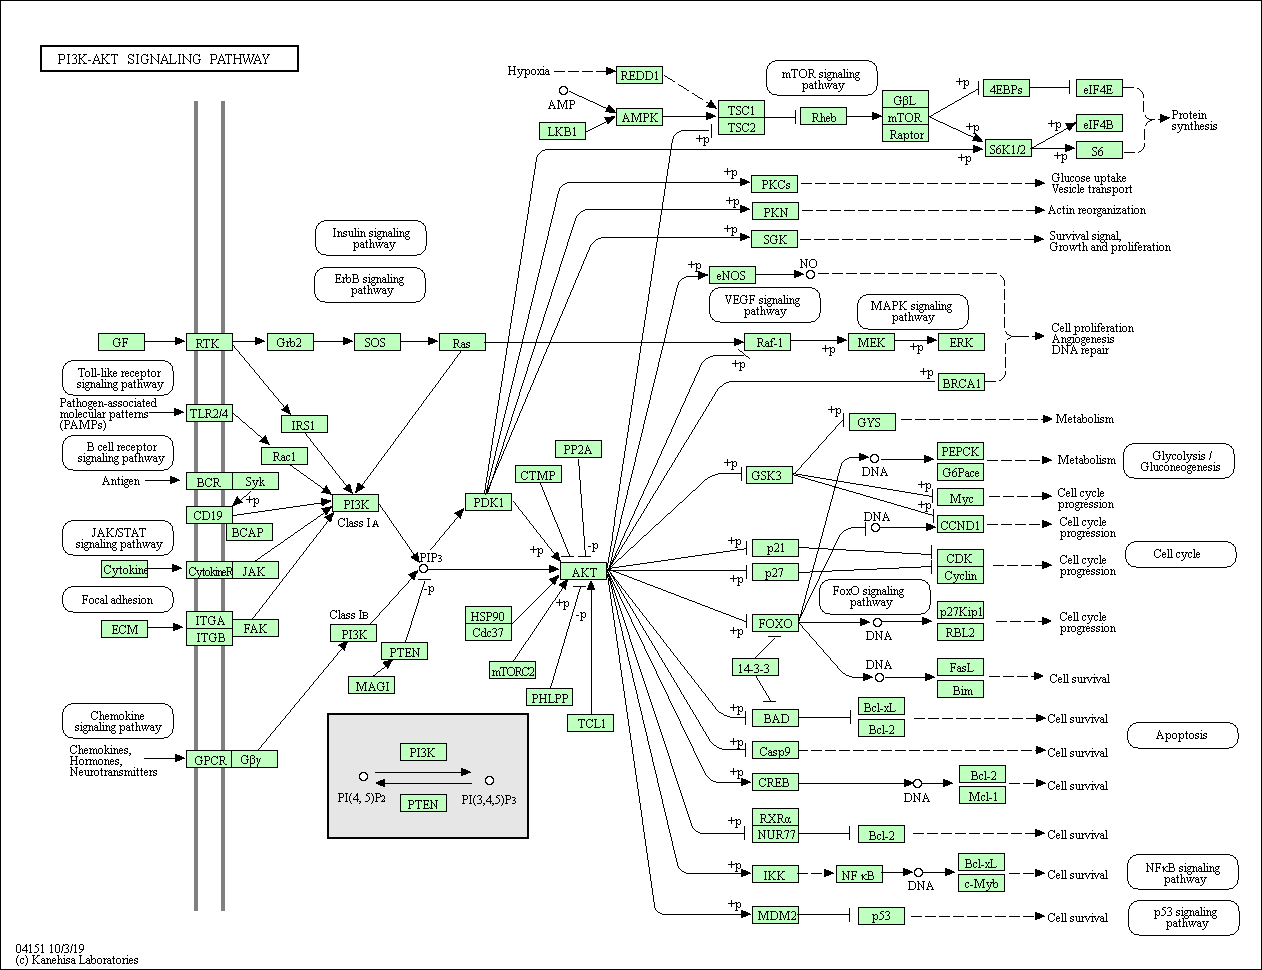

In [ ]:
from IPython.display import Image
from Bio.KEGG.KGML.KGML_parser import read
s = REST.kegg_get("hsa04151","image").read()
Image(s)

In [ ]:
from IPython.display import Image
from Bio.KEGG.KGML.KGML_parser import read
import random
s = REST.kegg_get("hsa04151","kgml").read()
tmp_list = [str(read(s).relations[0].type) for i in range(read(s).relations.__len__())]

In [ ]:
read(s).relations.__len__()

85

In [ ]:
random.seed(30)
dict_kegg_tmp = []

for i in range(read(s).relations.__len__()):
  try:
    node_1 = str(read(s).relations[i]).split("\n")[3]
    node_2 = str(read(s).relations[i]).split("\n")[11]
    relations = str(read(s).relations[i]).split("\n")[18]
    types = str(read(s).relations[i].type)
    tmp_res_02 = [types,relations,node_1,"=",node_2]
    res_bool = " ".join(tmp_res_02).replace("Names:","")
    #print(res_bool)
    open("test_03.txt","a").write(res_bool + "\n")
  except Exception:
    pass

In [ ]:
d = open("test_03.txt", "r")
d.read()

'PPrel -->  hsa:3164 =  hsa:100533105 hsa:10110 hsa:23678 hsa:6446\nPPrel --|  hsa:23035 hsa:23239 =  hsa:2997 hsa:2998\nPPrel -->  undefined =  hsa:10000 hsa:207 hsa:208\nPPrel -->  undefined =  hsa:6009\nPPrel -->  cpd:C05981 =  hsa:596\nPPrel --|  hsa:1436 hsa:1956 hsa:1969 hsa:2064 hsa:2065 hsa:2066 hsa:2260 hsa:2261 hsa:2263 hsa:2264 hsa:2321 hsa:2322 hsa:2324 hsa:3480 hsa:3643 hsa:3791 hsa:3815 hsa:4233 hsa:4804 hsa:4914 hsa:4915 hsa:5156 hsa:5159 hsa:7010 =  hsa:595\nPPrel -->  hsa:6198 hsa:6199 =  cpd:C05981\nGErel --|  undefined =  hsa:596\nGErel -->  hsa:2309 =  hsa:5170\nGErel --|  hsa:10000 hsa:207 hsa:208 =  hsa:10000 hsa:207 hsa:208\nPPrel -->  hsa:572 =  hsa:5562 hsa:5563\nPPrel -->  hsa:2309 =  hsa:4193\nPPrel -->  hsa:4193 =  hsa:1978\nPPrel -->  hsa:28227 hsa:55012 hsa:5515 hsa:5516 hsa:5518 hsa:5519 hsa:5520 hsa:5521 hsa:5522 hsa:5523 hsa:5525 hsa:5526 hsa:5527 hsa:5528 hsa:5529 hsa:55844 =  hsa:4193\nPPrel -->  hsa:3164 =  hsa:672\nGErel -->  hsa:3265 hsa:3845 hsa:4

##Cell line

# Data Preparation

In [11]:
df_model = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/sample.txt",sep="\t").iloc[:,np.r_[1,2,6]]
df_model

,drug_row,drug_col,synergy_loewe
0,5-FU,ABT-888,-10.71
1,5-FU,ABT-888,-12.55
2,5-FU,ABT-888,-4.03
3,5-FU,ABT-888,-9.40
4,5-FU,AZD1775,-1.11
...,...,...,...
45610,VISMODEGIB,ADM HYDROCHLORIDE,-2.56
45611,CRIZOTINIB,ADM HYDROCHLORIDE,-19.71
45612,CABAZITAXEL,ADM HYDROCHLORIDE,-8.26
45613,VANDETANIB,ADM HYDROCHLORIDE,2.77


##Intersect detectable drug from all feature

In [ ]:
#target protein & drug structure
available_drug = list(target_protein.keys() & feat_mat.keys())
available_drug

In [18]:
target_protein_01 = {k: target_protein[k] for k in set(available_drug) & set(target_protein.keys())}
#detected drug
drug_number = list(target_protein_01.values()).__len__()
newDF = pd.DataFrame() 

for i in range(drug_number):
  df_annotated = pd.DataFrame(pd.DataFrame(list(target_protein_01.values())[i].tolist()))
  df_annotated["drug"] = list(target_protein_01.keys())[i]
  newDF = df_annotated.append(newDF)
newDF.columns = ['protein',"drug"]
newDF

,protein,drug
0,9606.ENSP00000266970,DINACICLIB
1,9606.ENSP00000378699,DINACICLIB
2,9606.ENSP00000362361,DINACICLIB
3,9606.ENSP00000419782,DINACICLIB
4,9606.ENSP00000269305,DINACICLIB
...,...,...
5,9606.ENSP00000263800,CRIZOTINIB
6,9606.ENSP00000301178,CRIZOTINIB
7,9606.ENSP00000295408,CRIZOTINIB
8,9606.ENSP00000376684,CRIZOTINIB


In [88]:
df_model_02 = df_model.groupby(['drug_row','drug_col']).agg({'synergy_loewe': 'mean'}).reset_index()
df_model_03 = df_model_02[df_model_02.drug_row.isin(newDF.drug.unique().tolist())]
df_model_04 = df_model_03[df_model_03.drug_col.isin(newDF.drug.unique().tolist())]
df_model_04

,drug_row,drug_col,synergy_loewe
105,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,-10.583333
106,5-FLUORO-2'-DEOXYURIDINE,AMINOLEVULINIC ACID HYDROCHLORIDE,-8.270000
107,5-FLUORO-2'-DEOXYURIDINE,ANASTROZOLE,-3.548333
108,5-FLUORO-2'-DEOXYURIDINE,ANTIBIOTIC AD 32,-5.140000
109,5-FLUORO-2'-DEOXYURIDINE,ANTIBIOTIC AY 22989,-6.008333
...,...,...,...
5847,ZOLINZA,TOPOTECAN,4.773750
5848,ZOLINZA,TOPOTECAN HYDROCHLORIDE,-12.246667
5849,ZOLINZA,TRIETHYLENEMELAMINE,1.803333
5850,ZOLINZA,VINBLASTINE SULFATE,-1.546667


###Target Protein

In [89]:
crosstab_df_target_protein = pd.crosstab(newDF["drug"],newDF['protein']).stack().reset_index(name='Freq')
crosstab_df_target_protein_02 = pd.pivot_table(crosstab_df_target_protein,index='drug', columns='protein',values='Freq').reset_index()
crosstab_df_target_protein_03 = crosstab_df_target_protein_02.iloc[:,0:]
crosstab_df_target_protein_03

protein,drug,9606.ENSP00000001008,9606.ENSP00000001146,9606.ENSP00000013807,9606.ENSP00000037502,9606.ENSP00000080059,9606.ENSP00000206249,9606.ENSP00000211122,9606.ENSP00000215832,9606.ENSP00000216117,9606.ENSP00000216330,9606.ENSP00000216714,9606.ENSP00000216911,9606.ENSP00000217133,9606.ENSP00000217185,9606.ENSP00000217426,9606.ENSP00000218032,9606.ENSP00000219431,9606.ENSP00000219700,9606.ENSP00000220764,9606.ENSP00000220809,9606.ENSP00000221130,9606.ENSP00000221930,9606.ENSP00000222390,9606.ENSP00000222982,9606.ENSP00000223095,9606.ENSP00000225474,9606.ENSP00000225577,9606.ENSP00000226413,9606.ENSP00000226730,9606.ENSP00000227507,9606.ENSP00000227758,9606.ENSP00000228682,9606.ENSP00000229135,9606.ENSP00000229239,9606.ENSP00000231449,9606.ENSP00000231509,9606.ENSP00000231790,9606.ENSP00000231948,9606.ENSP00000233146,...,9606.ENSP00000387699,9606.ENSP00000388648,9606.ENSP00000388902,9606.ENSP00000391676,9606.ENSP00000393583,9606.ENSP00000394932,9606.ENSP00000396308,9606.ENSP00000396704,9606.ENSP00000398495,9606.ENSP00000398698,9606.ENSP00000399985,9606.ENSP00000400175,9606.ENSP00000402084,9606.ENSP00000402861,9606.ENSP00000408632,9606.ENSP00000408695,9606.ENSP00000408860,9606.ENSP00000410076,9606.ENSP00000411532,9606.ENSP00000412237,9606.ENSP00000413074,9606.ENSP00000414334,9606.ENSP00000417281,9606.ENSP00000417517,9606.ENSP00000418532,9606.ENSP00000418960,9606.ENSP00000419692,9606.ENSP00000419782,9606.ENSP00000420168,9606.ENSP00000425561,9606.ENSP00000427562,9606.ENSP00000430075,9606.ENSP00000430432,9606.ENSP00000434516,9606.ENSP00000441927,9606.ENSP00000457706,9606.ENSP00000459962,9606.ENSP00000462196,9606.ENSP00000463999,9606.ENSP00000464149
0,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,5-FU,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ABIRATERONE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ABT-888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ACTINOMYCIN D,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,VINCRISTINE SULFATE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
104,VINORELBINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105,VISMODEGIB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
106,ZOLEDRONIC ACID,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
newDF_prot = pd.DataFrame()

for i in range(df_model_04.shape[0]):
  print(i)
  index_drug = df_model_04.iloc[df_model_04.shape[0]-1-i,:2].tolist()
  drug_row = crosstab_df_target_protein_03[crosstab_df_target_protein_03.drug == index_drug[0]]
  drug_row_02 = drug_row.rename(columns={'drug': 'drug_row'})
  drug_col = crosstab_df_target_protein_03[crosstab_df_target_protein_03["drug"] == index_drug[1]]
  drug_col_02 = drug_col.rename(columns={'drug': 'drug_col'})
  res_app = pd.concat([drug_row_02.reset_index(drop=True),drug_col_02.reset_index(drop=True)],axis=1)
  res_app_2 = res_app.sort_index(axis=1).iloc[:,:988]
  res_app_tmp = res_app.sort_index(axis=1).iloc[:,988:]
  final_df = pd.concat([res_app_tmp,res_app_2],axis=1)
  newDF_prot = final_df.append(newDF_prot) 

In [174]:
newDF_prot

protein,drug_col,drug_row,9606.ENSP00000001008,9606.ENSP00000001008,9606.ENSP00000001146,9606.ENSP00000001146,9606.ENSP00000013807,9606.ENSP00000013807,9606.ENSP00000037502,9606.ENSP00000037502,9606.ENSP00000080059,9606.ENSP00000080059,9606.ENSP00000206249,9606.ENSP00000206249,9606.ENSP00000211122,9606.ENSP00000211122,9606.ENSP00000215832,9606.ENSP00000215832,9606.ENSP00000216117,9606.ENSP00000216117,9606.ENSP00000216330,9606.ENSP00000216330,9606.ENSP00000216714,9606.ENSP00000216714,9606.ENSP00000216911,9606.ENSP00000216911,9606.ENSP00000217133,9606.ENSP00000217133,9606.ENSP00000217185,9606.ENSP00000217185,9606.ENSP00000217426,9606.ENSP00000217426,9606.ENSP00000218032,9606.ENSP00000218032,9606.ENSP00000219431,9606.ENSP00000219431,9606.ENSP00000219700,9606.ENSP00000219700,9606.ENSP00000220764,9606.ENSP00000220764,...,9606.ENSP00000413074,9606.ENSP00000413074,9606.ENSP00000414334,9606.ENSP00000414334,9606.ENSP00000417281,9606.ENSP00000417281,9606.ENSP00000417517,9606.ENSP00000417517,9606.ENSP00000418532,9606.ENSP00000418532,9606.ENSP00000418960,9606.ENSP00000418960,9606.ENSP00000419692,9606.ENSP00000419692,9606.ENSP00000419782,9606.ENSP00000419782,9606.ENSP00000420168,9606.ENSP00000420168,9606.ENSP00000425561,9606.ENSP00000425561,9606.ENSP00000427562,9606.ENSP00000427562,9606.ENSP00000430075,9606.ENSP00000430075,9606.ENSP00000430432,9606.ENSP00000430432,9606.ENSP00000434516,9606.ENSP00000434516,9606.ENSP00000441927,9606.ENSP00000441927,9606.ENSP00000457706,9606.ENSP00000457706,9606.ENSP00000459962,9606.ENSP00000459962,9606.ENSP00000462196,9606.ENSP00000462196,9606.ENSP00000463999,9606.ENSP00000463999,9606.ENSP00000464149,9606.ENSP00000464149
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,AMINOLEVULINIC ACID HYDROCHLORIDE,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,ANASTROZOLE,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,ANTIBIOTIC AD 32,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,ANTIBIOTIC AY 22989,5-FLUORO-2'-DEOXYURIDINE,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,TOPOTECAN,ZOLINZA,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,TOPOTECAN HYDROCHLORIDE,ZOLINZA,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,TRIETHYLENEMELAMINE,ZOLINZA,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,VINBLASTINE SULFATE,ZOLINZA,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [175]:
newDF_prot_02 = pd.DataFrame() 
i = list(newDF_prot.iloc[:,2:].columns.unique())
for k in i:
  x = pd.DataFrame(newDF_prot.loc[:,k].sum(axis=1))
  x.columns = [k]
  newDF_prot_02 = pd.concat([x,newDF_prot_02],axis=1)
final_df_ordinal = pd.concat([newDF_prot.iloc[:,:2], newDF_prot_02],axis=1)
print(final_df_ordinal)

                             drug_col  ... 9606.ENSP00000001008
0                          AMIFOSTINE  ...                    0
0   AMINOLEVULINIC ACID HYDROCHLORIDE  ...                    0
0                         ANASTROZOLE  ...                    0
0                    ANTIBIOTIC AD 32  ...                    0
0                 ANTIBIOTIC AY 22989  ...                    1
..                                ...  ...                  ...
0                           TOPOTECAN  ...                    0
0             TOPOTECAN HYDROCHLORIDE  ...                    0
0                 TRIETHYLENEMELAMINE  ...                    0
0                 VINBLASTINE SULFATE  ...                    0
0                     ZOLEDRONIC ACID  ...                    0

[4211 rows x 496 columns]


In [176]:
final_df_ordinal.iloc[:,:2]

,drug_col,drug_row
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE
0,AMINOLEVULINIC ACID HYDROCHLORIDE,5-FLUORO-2'-DEOXYURIDINE
0,ANASTROZOLE,5-FLUORO-2'-DEOXYURIDINE
0,ANTIBIOTIC AD 32,5-FLUORO-2'-DEOXYURIDINE
0,ANTIBIOTIC AY 22989,5-FLUORO-2'-DEOXYURIDINE
...,...,...
0,TOPOTECAN,ZOLINZA
0,TOPOTECAN HYDROCHLORIDE,ZOLINZA
0,TRIETHYLENEMELAMINE,ZOLINZA
0,VINBLASTINE SULFATE,ZOLINZA


In [197]:
score = pd.DataFrame(df_model_04.iloc[:,2]).reset_index(drop=True)
f1 = final_df_ordinal.reset_index(drop=True)
target_protein_df = pd.concat([f1,score],axis=1)

###Drug structure

In [ ]:
target_protein_01 = {k: target_protein[k] for k in set(available_drug) & set(target_protein.keys())}
drug_structure_01 = {k: feat_mat[k] for k in set(available_drug) & set(feat_mat.keys())}

#Model

In [ ]:
class GraphConv(Layer):
    
    """
    GraphConv require two inputs: padding feature and padding adjacency matrix of each drug

    """
    def __init__(self,output_dim,activation="sigmoid"):
        super().__init__()
        self.units = output_dim
        self.activation_function = activation

    def build(self, input_shape):
        
        """ 
        weight in GCN : 
        row is number of feature
        column is the number of output node

        """
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units), 
            initializer="random_normal",
            trainable=True)
        
    

    def call(self,inputs):
      """
      Inputs = padding feature matrix 
      A = padding adjacency matrix

      """
      if self.activation_function == 'relu':
        return relu(inputs @ self.w)
      else:
        return sigmoid(inputs @ self.w)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 4         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
None


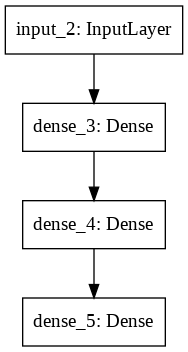

In [46]:
# first input model

#boolean
#visible1 = Input(shape=(10,30))
#layer1 = GraphConv(2,activation='relu')(visible1)
#layer2 = GraphConv(2,activation='relu')(layer1)
#pool12 = tf.keras.layers.MaxPooling1D()(layer2)
#flat1 = Flatten()(pool12)

#drug structure
#visible2 = Input(shape=(30,70))
#layer1 = GraphConv(2,activation='relu')(visible2)
#layer2 = GraphConv(10,activation='relu')(layer1)
#pool12 = tf.keras.layers.MaxPooling1D()(layer2)
#flat2 = Flatten()(pool12)

#target protein
flat3 = Input(shape=(1,))

#cell line
#flat4 = Input(shape=(30,))


# merge input models
#merge = concatenate([flat1,flat2,flat3,flat4])

# interpretation model
hidden1 = Dense(2, activation='relu')(flat3)
hidden2 = Dense(2, activation='relu')(hidden1)
output = Dense(1)(hidden2)
model = Model(inputs=flat3, outputs=output)
#model = Model(inputs=[visible1,visible2,flat3,flat4], outputs=output)
# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file='multilayer_perceptron_graph.png')

##Simulate data

In [269]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters

In [291]:
from keras import backend as K
def matthews_correlation_coefficient(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

In [292]:
def tune_nn_model(hp):
    flat3 = Input(shape=(494,))
    hidden1 = Dense(512, activation='relu')(flat3)
    hidden2 = Dense(256, activation='relu')(hidden1)
    output = Dense(1)(hidden2)
    model = Model(inputs=flat3, outputs=output)
    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate',min_value=1e-5,max_value=1e-2,sampling='LOG',default=1e-3)),loss='mse',
                  metrics=['mse',matthews_correlation_coefficient])
    return model

In [316]:
b_tuner = BayesianOptimization(
    tune_nn_model,
    objective='mean_squared_error',
    max_trials=30,
    directory='tffi1'
)

In [317]:
b_tuner.search_space_summary()

Search space summary
Default search space size: 1
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [295]:
target_protein_df.head()

,drug_col,drug_row,9606.ENSP00000464149,9606.ENSP00000463999,9606.ENSP00000462196,9606.ENSP00000459962,9606.ENSP00000457706,9606.ENSP00000441927,9606.ENSP00000434516,9606.ENSP00000430432,9606.ENSP00000430075,9606.ENSP00000427562,9606.ENSP00000425561,9606.ENSP00000420168,9606.ENSP00000419782,9606.ENSP00000419692,9606.ENSP00000418960,9606.ENSP00000418532,9606.ENSP00000417517,9606.ENSP00000417281,9606.ENSP00000414334,9606.ENSP00000413074,9606.ENSP00000412237,9606.ENSP00000411532,9606.ENSP00000410076,9606.ENSP00000408860,9606.ENSP00000408695,9606.ENSP00000408632,9606.ENSP00000402861,9606.ENSP00000402084,9606.ENSP00000400175,9606.ENSP00000399985,9606.ENSP00000398698,9606.ENSP00000398495,9606.ENSP00000396704,9606.ENSP00000396308,9606.ENSP00000394932,9606.ENSP00000393583,9606.ENSP00000391676,9606.ENSP00000388902,...,9606.ENSP00000233146,9606.ENSP00000231948,9606.ENSP00000231790,9606.ENSP00000231509,9606.ENSP00000231449,9606.ENSP00000229239,9606.ENSP00000229135,9606.ENSP00000228682,9606.ENSP00000227758,9606.ENSP00000227507,9606.ENSP00000226730,9606.ENSP00000226413,9606.ENSP00000225577,9606.ENSP00000225474,9606.ENSP00000223095,9606.ENSP00000222982,9606.ENSP00000222390,9606.ENSP00000221930,9606.ENSP00000221130,9606.ENSP00000220809,9606.ENSP00000220764,9606.ENSP00000219700,9606.ENSP00000219431,9606.ENSP00000218032,9606.ENSP00000217426,9606.ENSP00000217185,9606.ENSP00000217133,9606.ENSP00000216911,9606.ENSP00000216714,9606.ENSP00000216330,9606.ENSP00000216117,9606.ENSP00000215832,9606.ENSP00000211122,9606.ENSP00000206249,9606.ENSP00000080059,9606.ENSP00000037502,9606.ENSP00000013807,9606.ENSP00000001146,9606.ENSP00000001008,synergy_loewe
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-10.583333
1,AMINOLEVULINIC ACID HYDROCHLORIDE,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-8.270000
2,ANASTROZOLE,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-3.548333
3,ANTIBIOTIC AD 32,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-5.140000
4,ANTIBIOTIC AY 22989,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,-6.008333


In [213]:
x_train = target_protein_df.iloc[:,2:496]
y_train = target_protein_df.iloc[:,496]

In [318]:
b_tuner.search(x=x_train,
             y=y_train,
             epochs=30)


Trial 10 Complete [00h 00m 23s]
mean_squared_error: 5.521643161773682

Best mean_squared_error So Far: 5.3046770095825195
Total elapsed time: 00h 04m 07s

Search: Running Trial #11

Hyperparameter    |Value             |Best Value So Far 
learning_rate     |0.0024142         |0.0025472         

Train on 4211 samples
Epoch 1/30
4211/4211 [==============================] - 1s 213us/sample - loss: 93.7042 - mean_squared_error: 93.7042 - matthews_correlation_coefficient: 0.6705
Epoch 2/30
4211/4211 [==============================] - 1s 171us/sample - loss: 70.7815 - mean_squared_error: 70.7815 - matthews_correlation_coefficient: 0.6890
Epoch 3/30
4211/4211 [==============================] - 1s 183us/sample - loss: 46.2692 - mean_squared_error: 46.2692 - matthews_correlation_coefficient: 0.7146
Epoch 4/30
4211/4211 [==============================] - 1s 178us/sample - loss: 34.7984 - mean_squared_error: 34.7983 - matthews_correlation_coefficient: 0.7462
Epoch 5/30
4211/4211 [===============

KeyboardInterrupt: ignored

In [310]:
b_tuner.results_summary()
best_hps = b_tuner.get_best_hyperparameters(num_trials = 1)[0]

Results summary
Results in tfsfi1/untitled_project
Showing 10 best trials
Objective(name='mean_squared_error', direction='min')
Trial summary
Hyperparameters:
learning_rate: 0.0022796739488448498
Score: 11.701502799987793
Trial summary
Hyperparameters:
learning_rate: 0.0002935894587830842
Score: 23.86089324951172
Trial summary
Hyperparameters:
learning_rate: 2.2473833926205203e-05
Score: 89.87991333007812


In [312]:
# Build the model with the optimal hyperparameters and train it on the data
model = b_tuner.hypermodel.build(best_hps)
model.fit(x_train,y_train, epochs = 30)


Train on 4211 samples
Epoch 1/3
4211/4211 [==============================] - 1s 186us/sample - loss: 94.8919 - mean_squared_error: 94.8919 - matthews_correlation_coefficient: 0.6722
Epoch 2/3
4211/4211 [==============================] - 1s 170us/sample - loss: 67.4765 - mean_squared_error: 67.4765 - matthews_correlation_coefficient: 0.7054
Epoch 3/3
4211/4211 [==============================] - 1s 175us/sample - loss: 45.8218 - mean_squared_error: 45.8218 - matthews_correlation_coefficient: 0.7263
